## データセットの準備

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import warnings
warnings.filterwarnings('ignore')

In [2]:
def space_clean(row):
    """空白文字を整理"""
    row = row.replace(". ", "").replace(" .", "").replace("  ", " ")
    return row

def canonicalize(smiles):
    """SMILESを正規化"""
    try:
        new_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True)
    except:
        new_smiles = None
    return new_smiles

In [3]:
# データ読み込み
df = pd.read_csv("../data/Suzuki-Miyaura/aap9112_reaction_t5_ready.csv")
print(f"データ数: {len(df)}")
df.head()

データ数: 3696


,REACTANT,REAGENT,CATALYST,SOLVENT,PRODUCT,YIELD
0,CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1B(O)O.C...,[Na+].[OH-],CC(=O)O.CC(=O)O.CC(C)(C)P(C(C)(C)C)C(C)(C)C.[Pd],CC#N.O,Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1,4.764109
1,CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1B(O)O.C...,[Na+].[OH-],CC(=O)O.CC(=O)O.[Pd],CC#N.O,Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1,4.120962
2,CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1B(O)O.C...,[Na+].[OH-],CC(=O)O.CC(=O)O.CN(C)c1ccc(P(C(C)(C)C)C(C)(C)C...,CC#N.O,Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1,2.583837
3,CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1B(O)O.C...,[Na+].[OH-],C1CCC(P(C2CCCCC2)C2CCCCC2)CC1.CC(=O)O.CC(=O)O....,CC#N.O,Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1,4.443171
4,CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1B(O)O.C...,[Na+].[OH-],CC(=O)O.CC(=O)O.Cc1ccccc1P(c1ccccc1C)c1ccccc1C...,CC#N.O,Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1,1.949874


In [4]:
# 必須カラムの存在チェックと補完
required_cols = ["REACTANT", "CATALYST", "REAGENT", "SOLVENT", "PRODUCT"]
for col in required_cols:
    if col not in df.columns:
        df[col] = ""

# YIELDを標準化（0-1に正規化）
if "YIELD" in df.columns:
    df["YIELD"] = df["YIELD"].clip(0, 100) / 100

In [5]:
# SMILES正規化と不正データ除去
for col in ["REAGENT", "REACTANT", "PRODUCT"]:
    df[col] = df[col].apply(space_clean)
    df[col] = df[col].apply(lambda x: canonicalize(x) if x != " " else " ")
    df = df[~df[col].isna()].reset_index(drop=True)
    df[col] = df[col].apply(lambda x: ".".join(sorted(x.split("."))))

In [ ]:
# CATALYST、REAGENT、SOLVENTを統合
# 欠損値を空文字列に置き換えて、空でない要素のみをドットで連結
def merge_components(catalyst, reagent, solvent):
    components = []
    if pd.notna(catalyst) and str(catalyst).strip():
        components.append(str(catalyst).strip())
    if pd.notna(reagent) and str(reagent).strip():
        components.append(str(reagent).strip())
    if pd.notna(solvent) and str(solvent).strip():
        components.append(str(solvent).strip())
    return ".".join(components) if components else ""

df["REAGENT"] = df.apply(lambda row: merge_components(row["CATALYST"], row["REAGENT"], row["SOLVENT"]), axis=1)

# REAGENTカラムもクリーニングと正規化
df["REAGENT"] = df["REAGENT"].apply(space_clean)

# REAGENTの各成分を正規化（複数のSMILESがドットで区切られている場合）
def canonicalize_components(smiles_str):
    """ドットで区切られた複数のSMILESを個別に正規化"""
    if not smiles_str or smiles_str.strip() == "":
        return ""
    components = smiles_str.split(".")
    canonicalized = []
    for comp in components:
        comp = comp.strip()
        if comp:
            canon = canonicalize(comp)
            if canon:
                canonicalized.append(canon)
    return ".".join(sorted(canonicalized)) if canonicalized else ""

df["REAGENT"] = df["REAGENT"].apply(canonicalize_components)

# 空のREAGENTを持つ行を削除
df = df[df["REAGENT"] != ""].reset_index(drop=True)

print(f"前処理後のデータ数: {len(df)}")

# 結合後のREAGENTの例を表示
print("\nREAGENTの例:")
for i in range(min(5, len(df))):
    print(f"  {i}: {df.loc[i, 'REAGENT']}")

前処理後のデータ数: 3696


## Morgan Fingerprintの計算

In [7]:
def smiles_to_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    """
    SMILESからMorgan Fingerprintを計算
    
    Args:
        smiles: SMILES文字列
        radius: Morgan Fingerprintの半径（デフォルト: 2）
        n_bits: ビット数（デフォルト: 2048）
    
    Returns:
        numpy array: フィンガープリントのビットベクトル
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(n_bits)
        fp = rdFingerprintGenerator.GetMorganGenerator(mol, radius, n_bits)
        return np.array(fp)
    except:
        return np.zeros(n_bits)

def reaction_to_fingerprint(reactant, reagent, product, radius=2, n_bits=2048):
    """
    反応物、試薬、生成物からMorgan Fingerprintを結合
    
    Args:
        reactant: 反応物のSMILES
        reagent: 試薬のSMILES
        product: 生成物のSMILES
        radius: Morgan Fingerprintの半径
        n_bits: 各分子のフィンガープリントのビット数
    
    Returns:
        numpy array: 結合されたフィンガープリント
    """
    fp_reactant = smiles_to_morgan_fingerprint(reactant, radius, n_bits)
    fp_reagent = smiles_to_morgan_fingerprint(reagent, radius, n_bits)
    fp_product = smiles_to_morgan_fingerprint(product, radius, n_bits)
    
    # 3つのフィンガープリントを結合
    return np.concatenate([fp_reactant, fp_reagent, fp_product])

In [8]:
# 全データのフィンガープリントを計算
print("Morgan Fingerprintを計算中...")
fingerprints = []
for idx, row in df.iterrows():
    fp = reaction_to_fingerprint(row["REACTANT"], row["REAGENT"], row["PRODUCT"])
    fingerprints.append(fp)
    if (idx + 1) % 100 == 0:
        print(f"  {idx + 1}/{len(df)} 完了")

X = np.array(fingerprints)
y = df["YIELD"].values * 100  # パーセント表記に戻す

print(f"\nフィンガープリントの形状: {X.shape}")
print(f"収率の範囲: {y.min():.2f}% - {y.max():.2f}%")

Morgan Fingerprintを計算中...
  100/3696 完了
  200/3696 完了
  300/3696 完了
  400/3696 完了
  500/3696 完了
  600/3696 完了
  700/3696 完了
  800/3696 完了
  900/3696 完了
  1000/3696 完了
  1100/3696 完了
  1200/3696 完了
  1300/3696 完了
  1400/3696 完了
  1500/3696 完了
  1600/3696 完了
  1700/3696 完了
  1800/3696 完了
  1900/3696 完了
  2000/3696 完了
  2100/3696 完了
  2200/3696 完了
  2300/3696 完了
  2400/3696 完了
  2500/3696 完了
  2600/3696 完了
  2700/3696 完了
  2800/3696 完了
  2900/3696 完了
  3000/3696 完了
  3100/3696 完了
  3200/3696 完了
  3300/3696 完了
  3400/3696 完了
  3500/3696 完了
  3600/3696 完了

フィンガープリントの形状: (3696, 6144)
収率の範囲: 0.00% - 100.00%


## ガウス過程回帰モデルの構築

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from scipy.stats import norm
import matplotlib.pyplot as plt
import os
import csv

In [10]:
def create_reaction_dictionaries(df):
    """
    データセットから反応辞書を作成
    
    Returns:
        tuple: (reactant_list, reagent_list, product_list, product_dict, true_yield_dict, fingerprint_dict)
    """
    reactant_list = sorted(df["REACTANT"].unique())
    reagent_list = sorted(df["REAGENT"].unique())
    product_list = sorted(df["PRODUCT"].unique())
    
    # (reactant, reagent) -> product のマッピング
    product_dict = {
        (row["REACTANT"], row["REAGENT"]): row["PRODUCT"]
        for _, row in df.iterrows()
    }
    
    # (reactant, reagent, product) -> yield のマッピング
    true_yield_dict = {
        (row["REACTANT"], row["REAGENT"], row["PRODUCT"]): row["YIELD"] * 100
        for _, row in df.iterrows()
    }
    
    # (reactant, reagent, product) -> fingerprint のマッピング
    fingerprint_dict = {}
    for idx, row in df.iterrows():
        key = (row["REACTANT"], row["REAGENT"], row["PRODUCT"])
        fingerprint_dict[key] = X[idx]
    
    print(f"Reactant候補数: {len(reactant_list)}")
    print(f"Reagent候補数: {len(reagent_list)}")
    print(f"Product候補数: {len(product_list)}")
    print(f"既知の組み合わせ数: {len(product_dict)}")
    
    return reactant_list, reagent_list, product_list, product_dict, true_yield_dict, fingerprint_dict

In [11]:
# 辞書の作成
reactant_list, reagent_list, product_list, product_dict, true_yield_dict, fingerprint_dict = create_reaction_dictionaries(df)

Reactant候補数: 12
Reagent候補数: 308
Product候補数: 1
既知の組み合わせ数: 3696


## ベイズ最適化の実装

In [12]:
class GaussianProcessBayesianOptimization:
    """
    ガウス過程回帰を使用したベイズ最適化
    Morgan Fingerprintを特徴量として使用
    """
    
    def __init__(self, reactant_list, reagent_list, product_dict, true_yield_dict, fingerprint_dict, output_dir="../runs/gpr_yield_NiB"):
        """
        Args:
            reactant_list: reactantの候補リスト
            reagent_list: reagentの候補リスト
            product_dict: (reactant, reagent) -> product のマッピング辞書
            true_yield_dict: (reactant, reagent, product) -> yield のマッピング辞書
            fingerprint_dict: (reactant, reagent, product) -> fingerprint のマッピング辞書
            output_dir: 出力ディレクトリ
        """
        self.reactant_list = reactant_list
        self.reagent_list = reagent_list
        self.product_dict = product_dict
        self.true_yield_dict = true_yield_dict
        self.fingerprint_dict = fingerprint_dict
        self.output_dir = output_dir
        
        # 全ての有効な組み合わせを事前計算
        self.valid_combinations = []
        for reactant in reactant_list:
            for reagent in reagent_list:
                if (reactant, reagent) in product_dict:
                    self.valid_combinations.append((reactant, reagent))
        
        print(f"有効な組み合わせ数: {len(self.valid_combinations)}")
        
        # ガウス過程回帰モデルの初期化
        kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(noise_level=1.0)
        self.gp_model = GaussianProcessRegressor(
            kernel=kernel,
            n_restarts_optimizer=10,
            normalize_y=True,
            alpha=1e-6
        )
        
        # 実験結果の記録
        self.experiment_history = []
        self.tried_combinations = set()
        self.X_train = []  # 学習用フィンガープリント
        self.y_train = []  # 学習用収率
        
        # 出力ディレクトリの作成
        os.makedirs(output_dir, exist_ok=True)
        self.log_csv_path = os.path.join(output_dir, "optimization_log.csv")
        self._init_csv_log()
    
    def _init_csv_log(self):
        """CSVログファイルの初期化"""
        if not os.path.exists(self.log_csv_path):
            with open(self.log_csv_path, "w", newline="", encoding="utf-8") as f:
                writer = csv.writer(f)
                writer.writerow([
                    "trial", "reactant", "reagent", "product",
                    "predicted_mean", "predicted_std", "actual_yield",
                    "error_pct", "acquisition_value"
                ])
    
    def _log_experiment_to_csv(self, experiment_result):
        """実験結果をCSVに記録"""
        with open(self.log_csv_path, "a", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow([
                experiment_result['trial'],
                experiment_result['reactant'],
                experiment_result['reagent'],
                experiment_result['product'],
                f"{experiment_result['predicted_mean']:.6f}",
                f"{experiment_result['predicted_std']:.6f}",
                f"{experiment_result['actual_yield']:.6f}",
                f"{experiment_result['error_pct']:+.6f}",
                f"{experiment_result['acquisition_value']:.6f}"
            ])
    
    def _predict_yield_with_uncertainty(self, fingerprints):
        """
        ガウス過程回帰による予測と不確実性の推定
        
        Args:
            fingerprints: フィンガープリントの配列 (n_samples, n_features)
        
        Returns:
            tuple: (予測平均, 予測標準偏差)
        """
        if len(self.X_train) == 0:
            # 初期状態ではランダムな予測
            n_samples = fingerprints.shape[0] if len(fingerprints.shape) > 1 else 1
            return np.ones(n_samples) * 50.0, np.ones(n_samples) * 30.0
        
        mean, std = self.gp_model.predict(fingerprints, return_std=True)
        return mean, std
    
    def _acquisition_function(self, mean, std, best_observed_yield, xi=0.01):
        """
        期待改善量（Expected Improvement）による獲得関数
        
        Args:
            mean: 予測平均
            std: 予測標準偏差
            best_observed_yield: これまでの最良収率
            xi: 探索と活用のトレードオフパラメータ
        
        Returns:
            期待改善量
        """
        if isinstance(std, np.ndarray):
            std = np.maximum(std, 1e-9)  # 数値安定性のため
        else:
            std = max(std, 1e-9)
        
        z = (mean - best_observed_yield - xi) / std
        ei = (mean - best_observed_yield - xi) * norm.cdf(z) + std * norm.pdf(z)
        return ei
    
    def _get_best_observed_yield(self):
        """これまでの最良収率を取得"""
        if len(self.experiment_history) > 0:
            return max([exp['actual_yield'] for exp in self.experiment_history])
        else:
            return 0.0
    
    def _select_next_candidate(self):
        """
        獲得関数に基づいて次の候補を選択
        """
        # 未試行の組み合わせを取得
        untried_combinations = [
            combo for combo in self.valid_combinations 
            if combo not in self.tried_combinations
        ]
        
        if not untried_combinations:
            print("全ての組み合わせを試行済みです。")
            return None
        
        # 獲得関数を計算
        best_yield = self._get_best_observed_yield()
        
        # フィンガープリントのリストを作成
        fingerprints = []
        for reactant, reagent in untried_combinations:
            product = self.product_dict[(reactant, reagent)]
            fp = self.fingerprint_dict[(reactant, reagent, product)]
            fingerprints.append(fp)
        
        fingerprints = np.array(fingerprints)
        
        print(f"獲得関数値を計算中... ({len(untried_combinations)}個の候補)")
        
        try:
            # バッチで予測実行
            pred_means, pred_stds = self._predict_yield_with_uncertainty(fingerprints)
            
            # 獲得関数値を計算
            acq_values = self._acquisition_function(pred_means, pred_stds, best_yield)
            
            # 最大獲得関数値のインデックス
            best_idx = np.argmax(acq_values)
            selected_combo = untried_combinations[best_idx]
            
            print(f"🎯 選択: {selected_combo} (EI: {acq_values[best_idx]:.4f})")
            
            return selected_combo
            
        except Exception as e:
            print(f"❌ エラー: {e}")
            # エラー時はランダム選択
            import random
            return random.choice(untried_combinations)
    
    def _evaluate_candidate(self, reactant, reagent, trial_num):
        """候補を評価（実験を実行）"""
        product = self.product_dict[(reactant, reagent)]
        fp = self.fingerprint_dict[(reactant, reagent, product)]
        
        # ガウス過程回帰による予測
        try:
            pred_mean, pred_std = self._predict_yield_with_uncertainty(fp.reshape(1, -1))
            pred_mean = float(pred_mean[0])
            pred_std = float(pred_std[0])
        except Exception as e:
            print(f"❌ 予測エラー: {e}")
            return None
        
        # 実際の収率を取得
        key = (reactant, reagent, product)
        actual_yield = self.true_yield_dict.get(key)
        
        if actual_yield is None:
            print(f"❗ 真値なし: {reactant} + {reagent} → {product}")
            actual_yield = 0.0
        
        # 獲得関数の計算
        best_yield = self._get_best_observed_yield()
        acquisition_value = float(self._acquisition_function(pred_mean, pred_std, best_yield))
        
        # 誤差の計算
        error_pct = pred_mean - actual_yield
        
        # 実験結果を記録
        experiment_result = {
            'trial': trial_num,
            'reactant': reactant,
            'reagent': reagent,
            'product': product,
            'predicted_mean': pred_mean,
            'predicted_std': pred_std,
            'actual_yield': actual_yield,
            'error_pct': error_pct,
            'acquisition_value': acquisition_value
        }
        
        # 出力
        print(f"🔎 Trial {trial_num}: {reactant} + {reagent} → {product}")
        print(f"   📈 予測: {pred_mean:.2f}% ± {pred_std:.2f}%")
        print(f"   🧪 真値: {actual_yield:.2f}%")
        print(f"   ❗ 誤差: {error_pct:+.2f}%")
        print(f"   🎯 獲得関数: {acquisition_value:.4f}")
        
        return experiment_result
    
    def _update_model(self, fingerprint, yield_value):
        """新しいデータでモデルを更新"""
        self.X_train.append(fingerprint)
        self.y_train.append(yield_value)
        
        # ガウス過程モデルを再学習
        X_train_array = np.array(self.X_train)
        y_train_array = np.array(self.y_train)
        
        print(f"   🔄 モデル更新中... (学習データ数: {len(self.X_train)})")
        self.gp_model.fit(X_train_array, y_train_array)
    
    def optimize(self, n_trials=50):
        """ベイズ最適化の実行"""
        print(f"ガウス過程ベイズ最適化を開始 ({n_trials}試行)")
        print("="*60)
        
        for trial in range(1, n_trials + 1):
            # 次の候補を選択
            candidate = self._select_next_candidate()
            if candidate is None:
                print("全ての組み合わせを試行完了。")
                break
            
            reactant, reagent = candidate
            product = self.product_dict[(reactant, reagent)]
            
            # 候補を評価
            result = self._evaluate_candidate(reactant, reagent, trial)
            if result is None:
                continue
            
            # 結果を記録
            self.experiment_history.append(result)
            self.tried_combinations.add((reactant, reagent))
            
            # CSVに記録
            self._log_experiment_to_csv(result)
            
            # モデルを更新
            fp = self.fingerprint_dict[(reactant, reagent, product)]
            self._update_model(fp, result['actual_yield'])
            
            # 進捗表示
            current_best = max([exp['actual_yield'] for exp in self.experiment_history])
            print(f"   💡 現在の最高収率: {current_best:.2f}%")
            print("-" * 60)
        
        print(f"\n最適化完了! 総試行数: {len(self.experiment_history)}")
        
        # 最終結果
        if self.experiment_history:
            best_exp = max(self.experiment_history, key=lambda x: x['actual_yield'])
            print(f"🏆 最高収率: {best_exp['actual_yield']:.2f}%")
            print(f"🏆 最適組み合わせ: {best_exp['reactant']} + {best_exp['reagent']} → {best_exp['product']}")
            return best_exp
        else:
            return None
    
    def get_optimization_summary(self):
        """最適化の概要統計を取得"""
        if not self.experiment_history:
            return {}
        
        actual_yields = [exp['actual_yield'] for exp in self.experiment_history]
        predicted_means = [exp['predicted_mean'] for exp in self.experiment_history]
        errors = [exp['error_pct'] for exp in self.experiment_history]
        
        return {
            'total_trials': len(self.experiment_history),
            'max_yield': max(actual_yields),
            'mean_yield': np.mean(actual_yields),
            'std_yield': np.std(actual_yields),
            'mae_error': np.mean(np.abs(errors)),
            'rmse_error': np.sqrt(np.mean(np.array(errors)**2)),
            'coverage': len(self.tried_combinations) / len(self.valid_combinations) * 100,
            'log_path': self.log_csv_path
        }
    
    def save_visualization(self):
        """最適化結果を可視化して保存"""
        if not self.experiment_history:
            print("実験履歴がありません。")
            return
        
        save_dir = os.path.join(self.output_dir, "visualization")
        os.makedirs(save_dir, exist_ok=True)
        
        trials = [exp['trial'] for exp in self.experiment_history]
        actual_yields = [exp['actual_yield'] for exp in self.experiment_history]
        predicted_means = [exp['predicted_mean'] for exp in self.experiment_history]
        predicted_stds = [exp['predicted_std'] for exp in self.experiment_history]
        errors = [exp['error_pct'] for exp in self.experiment_history]
        
        # 累積最大値
        cumulative_max = np.maximum.accumulate(actual_yields)
        
        # 1. Optimization Progress
        fig = plt.figure(figsize=(8, 5))
        plt.plot(trials, actual_yields, 'o-', alpha=0.6, label='Actual Yield', markersize=6)
        plt.plot(trials, cumulative_max, 'r-', linewidth=3, label='Best So Far')
        plt.xlabel('Trial')
        plt.ylabel('Yield [%]')
        plt.title('Optimization Progress')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'optimization_progress.png'), dpi=180, bbox_inches='tight')
        plt.close(fig)
        
        # 2. Parity Plot
        fig = plt.figure(figsize=(6, 6))
        plt.scatter(actual_yields, predicted_means, s=50, alpha=0.6)
        lims = [0, 100]
        plt.plot(lims, lims, 'r--', label='Perfect Prediction')
        plt.xlim(lims)
        plt.ylim(lims)
        plt.xlabel('Actual Yield [%]')
        plt.ylabel('Predicted Yield [%]')
        plt.title('Parity Plot')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'parity.png'), dpi=180, bbox_inches='tight')
        plt.close(fig)
        
        # 3. Prediction Uncertainty
        fig = plt.figure(figsize=(8, 5))
        plt.errorbar(trials, predicted_means, yerr=predicted_stds,
                    fmt='o', alpha=0.6, capsize=5, label='Prediction ± Uncertainty')
        plt.plot(trials, actual_yields, 'ro', alpha=0.6, label='Actual Yield')
        plt.xlabel('Trial')
        plt.ylabel('Yield [%]')
        plt.title('Prediction Uncertainty')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'uncertainty.png'), dpi=180, bbox_inches='tight')
        plt.close(fig)
        
        # 4. Error Trend
        fig = plt.figure(figsize=(8, 5))
        plt.plot(trials, errors, 'o-', alpha=0.6)
        plt.axhline(0, color='r', linestyle='--', label='Perfect Prediction')
        plt.xlabel('Trial')
        plt.ylabel('Prediction Error [%]')
        plt.title('Prediction Error Trend')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'error_trend.png'), dpi=180, bbox_inches='tight')
        plt.close(fig)
        
        # 5. Error Histogram
        fig = plt.figure(figsize=(7, 5))
        plt.hist(errors, bins=30, alpha=0.7, edgecolor='black')
        plt.axvline(0, color='r', linestyle='--', label='Perfect Prediction')
        plt.xlabel('Prediction Error [%]')
        plt.ylabel('Count')
        plt.title('Error Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'error_hist.png'), dpi=180, bbox_inches='tight')
        plt.close(fig)
        
        # 6. Uncertainty vs Actual Yield
        fig = plt.figure(figsize=(7, 5))
        plt.scatter(predicted_stds, actual_yields, alpha=0.6)
        plt.xlabel('Prediction Uncertainty (Std)')
        plt.ylabel('Actual Yield [%]')
        plt.title('Uncertainty vs Actual Yield')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'uncertainty_vs_yield.png'), dpi=180, bbox_inches='tight')
        plt.close(fig)
        
        print(f"可視化完了! 保存先: {save_dir}")

## ベイズ最適化の実行

In [13]:
# ベイズ最適化器を初期化
gp_optimizer = GaussianProcessBayesianOptimization(
    reactant_list=reactant_list,
    reagent_list=reagent_list,
    product_dict=product_dict,
    true_yield_dict=true_yield_dict,
    fingerprint_dict=fingerprint_dict,
    output_dir="../runs/gpr_100trials_SM"
)

有効な組み合わせ数: 3696


In [14]:
# ベイズ最適化の実行
best_result = gp_optimizer.optimize(n_trials=100)

# 最適化の概要統計を表示
summary = gp_optimizer.get_optimization_summary()
print(f"\n=== 最適化概要 ===")
print(f"総試行数: {summary.get('total_trials', 0)}")
print(f"最高収率: {summary.get('max_yield', 0):.2f}%")
print(f"平均収率: {summary.get('mean_yield', 0):.2f}%")
print(f"収率標準偏差: {summary.get('std_yield', 0):.2f}%")
print(f"予測誤差 (MAE): {summary.get('mae_error', 0):.2f}%")
print(f"予測誤差 (RMSE): {summary.get('rmse_error', 0):.2f}%")
print(f"探索範囲: {summary.get('coverage', 0):.1f}%")
print(f"ログファイル: {summary.get('log_path', 'N/A')}")

# 可視化を保存
gp_optimizer.save_visualization()

ガウス過程ベイズ最適化を開始 (100試行)
獲得関数値を計算中... (3696個の候補)
🎯 選択: ('Brc1ccc2ncccc2c1.CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1B(O)O', 'C1CCC(P(C2CCCCC2)C2CCCCC2)CC1.CC(=O)O.CC(=O)O.[Pd].CC(C)(C)[O-].[Li+].C1CCOC1.O') (EI: 50.5853)
🔎 Trial 1: Brc1ccc2ncccc2c1.CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1B(O)O + C1CCC(P(C2CCCCC2)C2CCCCC2)CC1.CC(=O)O.CC(=O)O.[Pd].CC(C)(C)[O-].[Li+].C1CCOC1.O → Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1
   📈 予測: 50.00% ± 30.00%
   🧪 真値: 73.60%
   ❗ 誤差: -23.60%
   🎯 獲得関数: 50.5853
   🔄 モデル更新中... (学習データ数: 1)
   💡 現在の最高収率: 73.60%
------------------------------------------------------------
獲得関数値を計算中... (3695個の候補)
🎯 選択: ('Brc1ccc2ncccc2c1.CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1B(O)O', 'C1CCC(P(C2CCCCC2)C2CCCCC2)CC1.CC(=O)O.CC(=O)O.[Pd].CC(C)(C)[O-].[Li+].CC#N.O') (EI: 0.0000)
🔎 Trial 2: Brc1ccc2ncccc2c1.CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1B(O)O + C1CCC(P(C2CCCCC2)C2CCCCC2)CC1.CC(=O)O.CC(=O)O.[Pd].CC(C)(C)[O-].[Li+].CC#N.O → Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1
   📈 予測: 73.60% ± 

## 可視化


### Optimization Progress


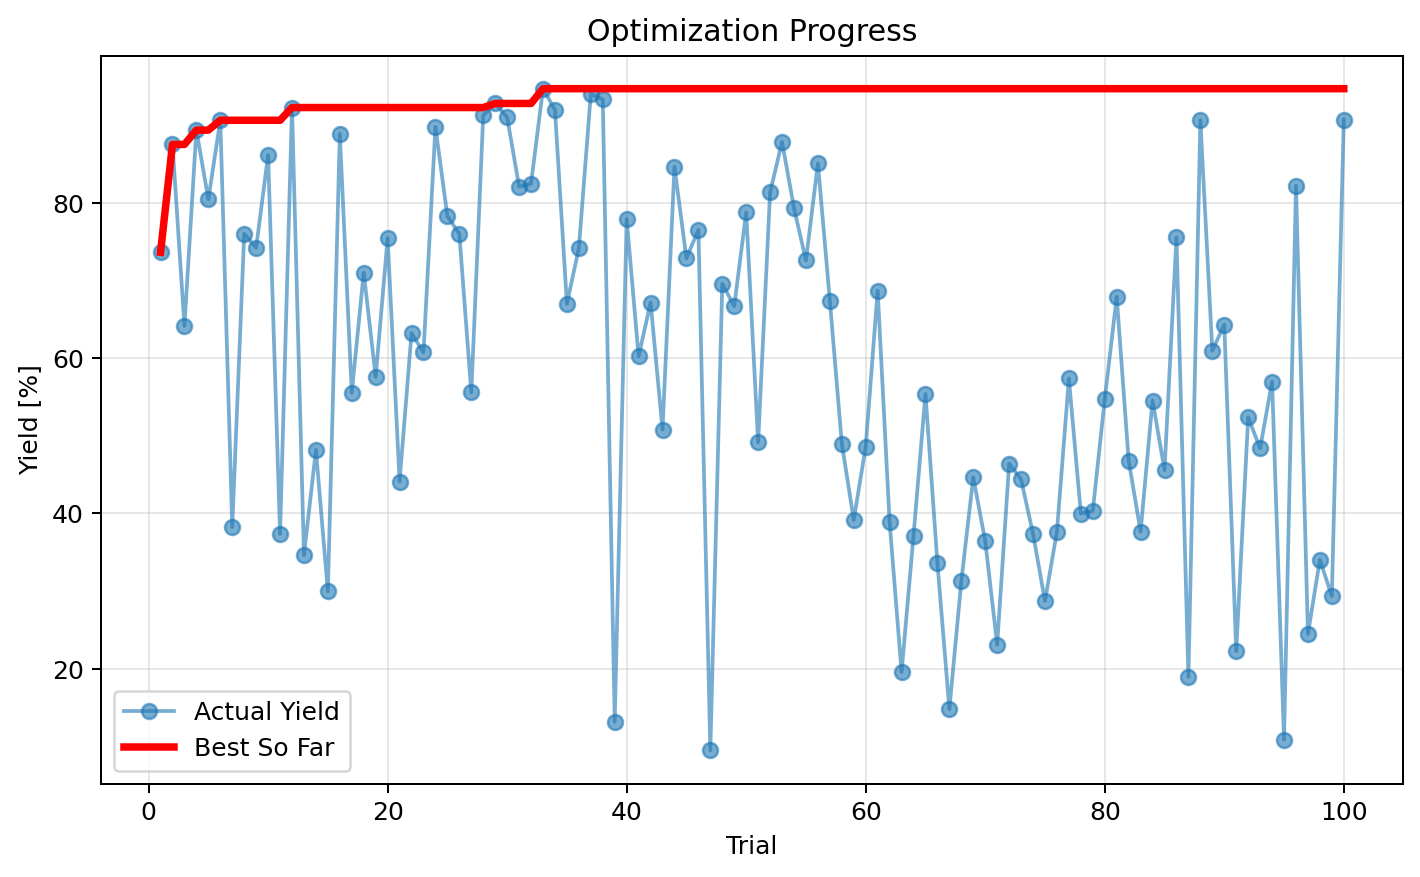


### Parity Plot


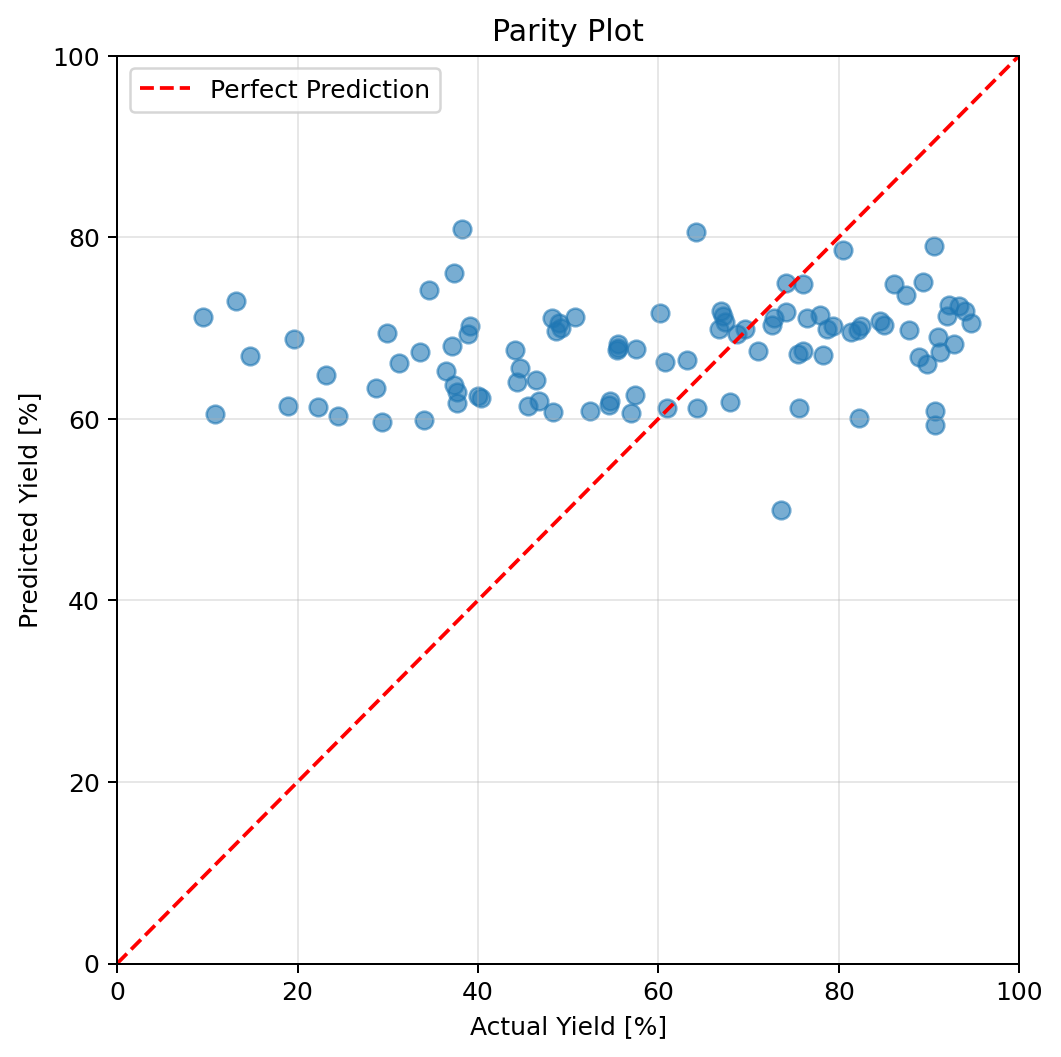


### Prediction Uncertainty


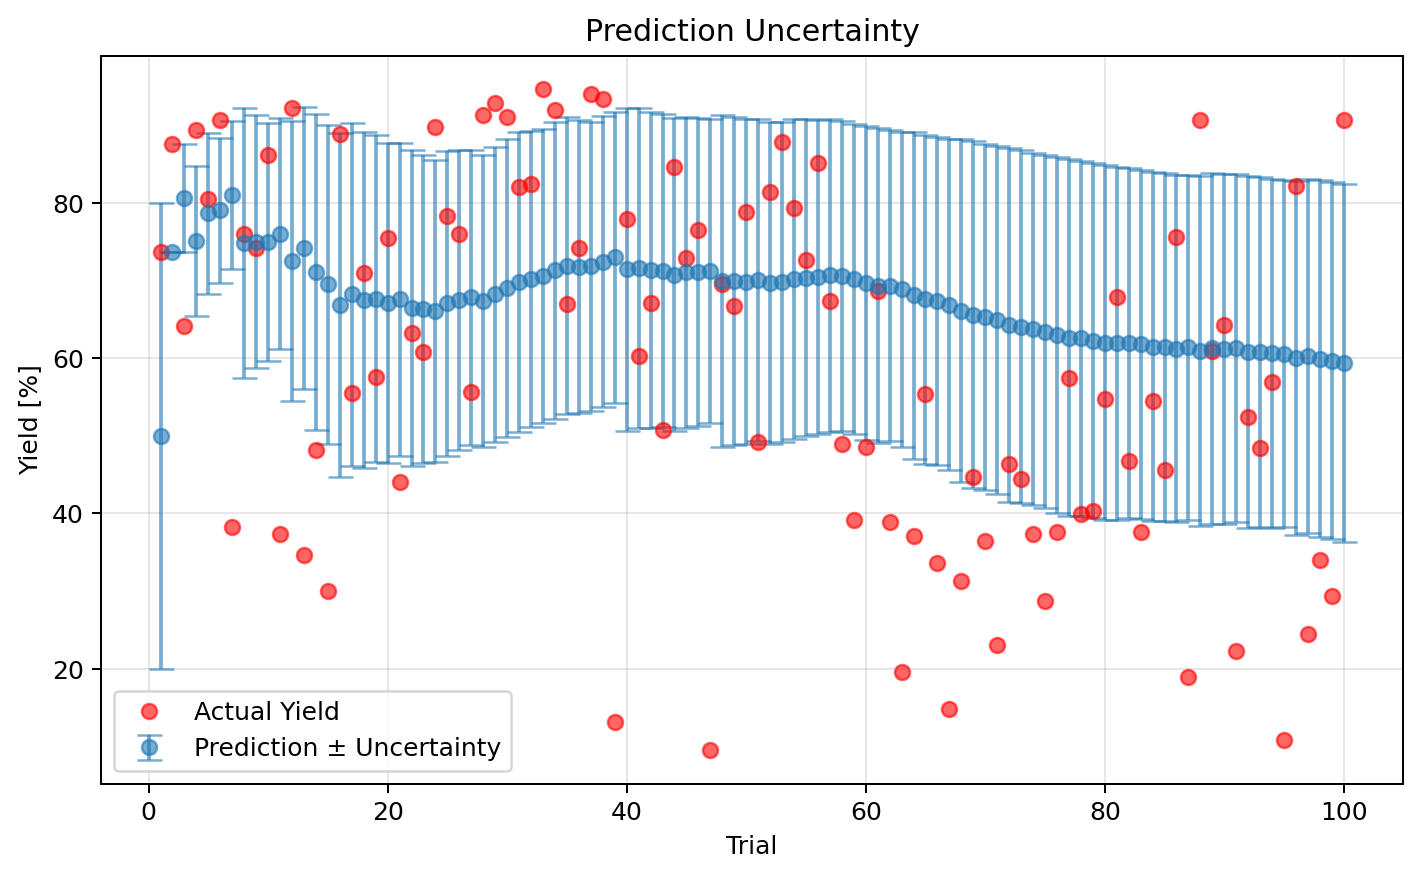


### Error Trend


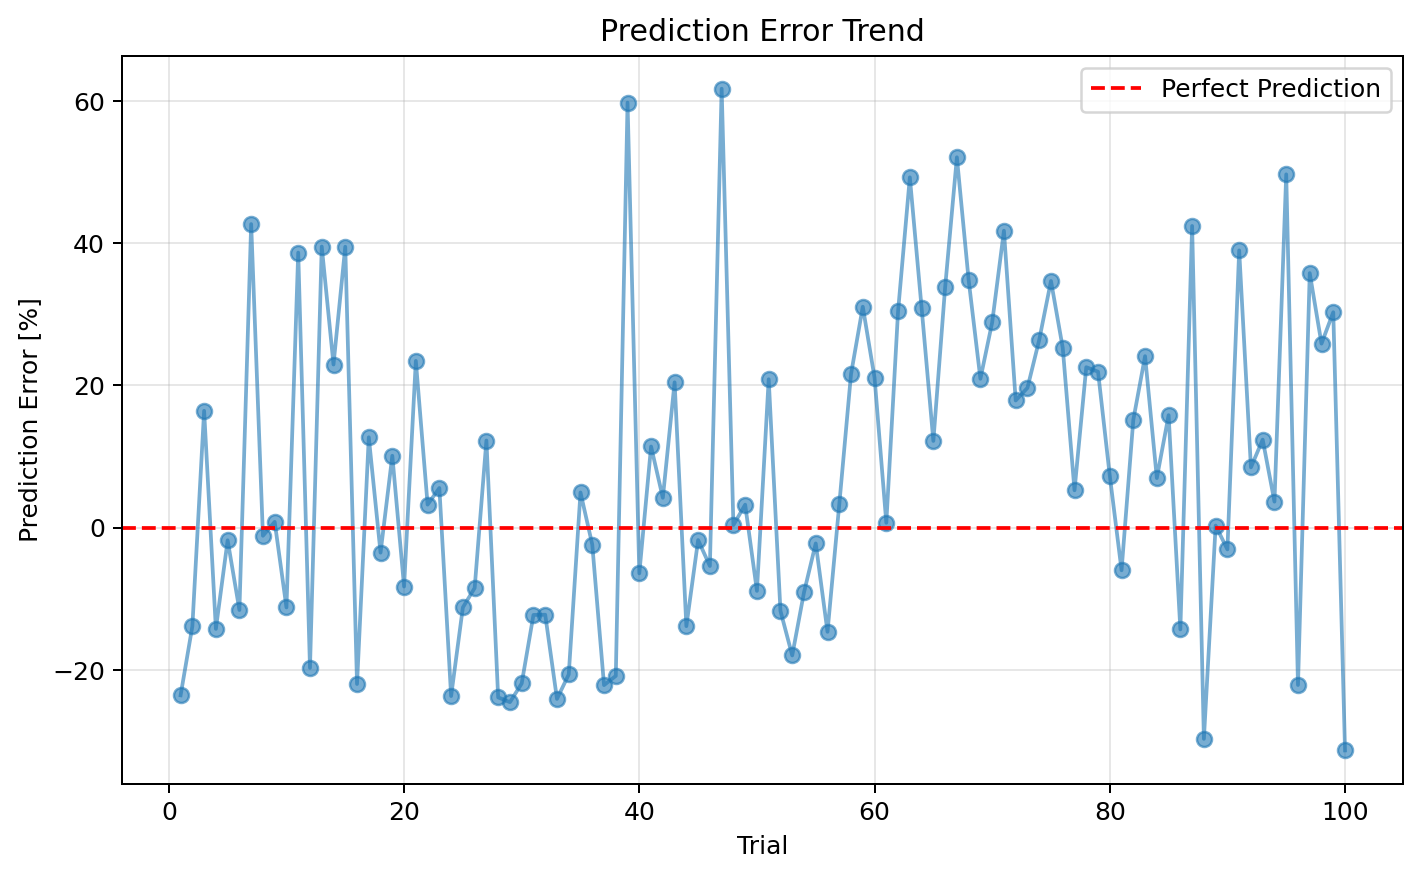


### Error Distribution


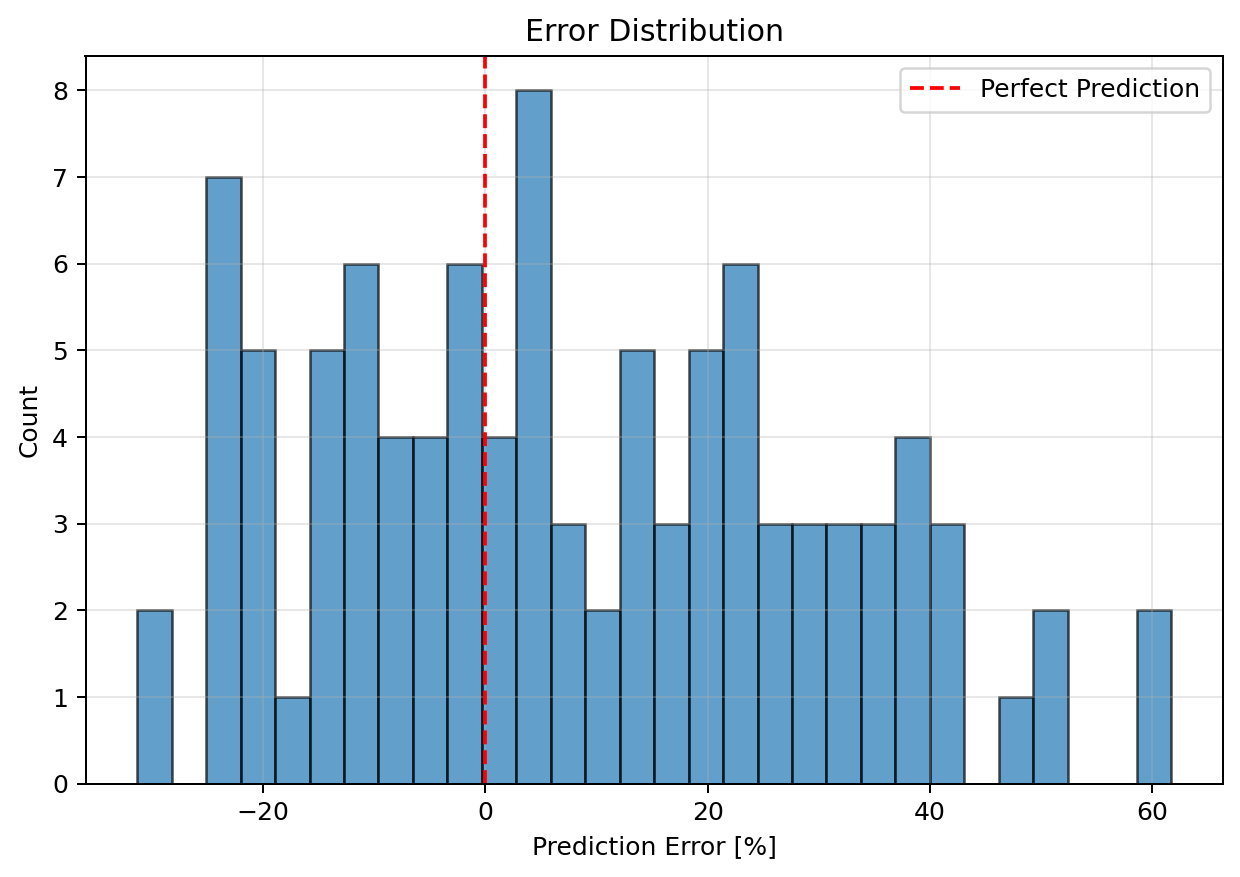


### Uncertainty vs Actual Yield


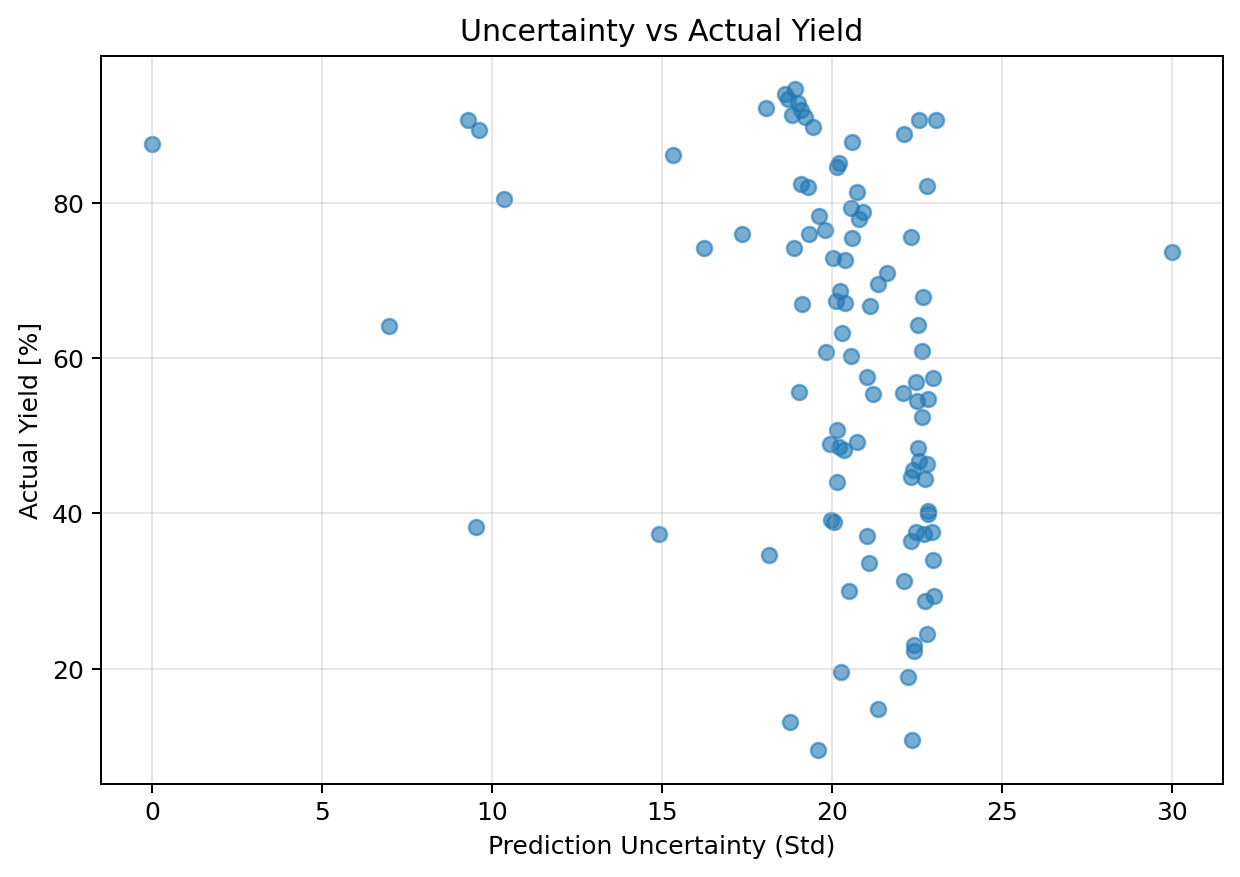

In [15]:
# 保存された可視化を表示
from IPython.display import Image, display

save_dir = os.path.join(gp_optimizer.output_dir, "visualization")

if os.path.exists(save_dir):
    plot_files = [
        ('optimization_progress.png', 'Optimization Progress'),
        ('parity.png', 'Parity Plot'),
        ('uncertainty.png', 'Prediction Uncertainty'),
        ('error_trend.png', 'Error Trend'),
        ('error_hist.png', 'Error Distribution'),
        ('uncertainty_vs_yield.png', 'Uncertainty vs Actual Yield')
    ]
    
    for filename, title in plot_files:
        filepath = os.path.join(save_dir, filename)
        if os.path.exists(filepath):
            print(f"\n### {title}")
            display(Image(filename=filepath))
else:
    print("可視化ファイルが見つかりません。")